### import librairies

In [11]:
# import librairies and functions needed for project

# utilities
import os
os.environ["OMP_NUM_THREADS"] = '1' # needed to avoid memory leak warning with K-Means in Windows environment
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

# data
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None) # maximise dataframe display

# modelisation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, fowlkes_mallows_score

# visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

In [12]:
# Import data & split file
data = pd.read_csv("df_final.csv", encoding='latin_1')

In [13]:
# Remplacer les valeurs dans la colonne "is_genuine"
data['is_genuine'] = data['is_genuine'].map({1: True, 0: False})

### train_test_split de notre jeu de données df_final (1500, 7)

In [14]:
# include all variables
x = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].values
y = data['is_genuine']

# labels
dimensions = data.columns.drop('is_genuine')

# create train & test data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True, stratify=None)

print(f"Nous avons x_train de forme {x_train.shape} et y_train de forme {y_train.shape}")
unique_yt, counts_yt = np.unique(y_train, return_counts=True)
print("True/False mix in training set:\n", np.asarray((unique_yt, counts_yt)).T)
print(f"Nous avons x_test de forme {x_test.shape} et y_test de forme {y_test.shape}")
unique_ytt, counts_ytt = np.unique(y_test, return_counts=True)
print("True/False mix in testing set:\n", np.asarray((unique_ytt, counts_ytt)).T)

Nous avons x_train de forme (1200, 6) et y_train de forme (1200,)
True/False mix in training set:
 [[  0 390]
 [  1 810]]
Nous avons x_test de forme (300, 6) et y_test de forme (300,)
True/False mix in testing set:
 [[  0 110]
 [  1 190]]


### Standardisation du jeu d'entrainement

In [15]:
# export training & testing sets to re-use for training logistic regression model
pd.DataFrame(x_train, columns=dimensions).to_csv('x_training_set.csv', index=None, encoding='latin_1')
y_train.to_csv('y_training_set.csv', index=False, encoding='latin_1')
pd.DataFrame(x_test, columns=dimensions).to_csv('x_testing_set.csv', index=None, encoding='latin_1')
y_test.to_csv('y_testing_set.csv', index=False, encoding='latin_1')

# center & reduce data
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

### Création d'un dataframe "clusters" des données normalisées

In [16]:
clusters = pd.DataFrame(y_train)
clusters[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
          'length']] = x_train_scaled
clusters['is_genuine'].value_counts()

is_genuine
True     810
False    390
Name: count, dtype: int64

## Entrainement de l'algorithme K-means à 2 clusters

In [17]:
# run K-means
kmeans_2 = KMeans(n_clusters=2, random_state=808, n_init="auto")
kmeans_2.fit(x_train_scaled)
labels_2 = kmeans_2.labels_

# add cluster number to each line in "clusters dataframe"
clusters['cluster_km_2'] = (kmeans_2.labels_)

In [18]:
inertie_2 = round(kmeans_2.inertia_, 2)
print(f"Inertie: {inertie_2} - Nb iterations: {kmeans_2.n_iter_} ")

Inertie: 4655.52 - Nb iterations: 5 


In [19]:
clusters.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
382         True  1.050853     1.958416     -0.367712   -0.597273  -0.306118  \
538         True -0.185700     1.559864     -1.317963   -0.597273  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618912   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728680   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445250  -1.126077   

        length  cluster_km_2  
382   0.648529             0  
538   0.921625             0  
1493 -0.603164             1  
1112 -1.229011             1  
324   0.716803             0

### Analyse des centroïdes

In [20]:
# create centroids dataframe
centroids_2 = kmeans_2.cluster_centers_
centroids_km_2 = pd.DataFrame(centroids_2)
centroids_km_2.columns = dimensions
centroids_km_2

diagonal  height_left  height_right  margin_low  margin_up    length
0  0.089125    -0.262568     -0.341261   -0.537078  -0.415777  0.582539
1 -0.190118     0.560100      0.727963    1.145673   0.886919 -1.242648

In [21]:
# plot polar chart centroids
categories = centroids_km_2.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_2.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_2.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroide'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.show()

In [22]:
clusters.loc[(clusters['is_genuine'] == True), 'real_label'] = 1
clusters.loc[(clusters['is_genuine'] == False), 'real_label'] = 0
clusters

is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
382         True  1.050853     1.958416     -0.367712   -0.597273  -0.306118  \
538         True -0.185700     1.559864     -1.317963   -0.597273  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618912   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728680   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445250  -1.126077   
...          ...       ...          ...           ...         ...        ...   
1130       False -1.292089     0.862396      0.827766    1.150992   2.067448   
1294       False  1.441344     0.795971      0.797113    0.679721   0.082284   
860         True -1.877825    -0.665389      0.214701   -0.049990  -0.133495   
1459       False -0.576190     0.928822     -0.306405    2.610413   0.427530   
1126       False -0.380945     0.098503      0.551887    0.603709   0.427530   

        length  cluster_km_2  real_label  
382   0.648529             0         1.0  
538   0.921625             0         1.0  
1493 -0.603164             1         0.0  
1112 -1.229011             1         0.0  
324   0.716803             0         1.0  
...        ...           ...         ...  
1130  0.284400             1         0.0  
1294 -1.024188             1         0.0  
860   0.898867             0         1.0  
1459 -1.763825             1         0.0  
1126 -1.877615             1         0.0  

[1200 rows x 9 columns]

In [23]:
# Convertir la variable 'clustered_by_kmean' de type int en float
clusters['real_label'] = clusters['real_label'].astype(int)

In [24]:
clusters

is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
382         True  1.050853     1.958416     -0.367712   -0.597273  -0.306118  \
538         True -0.185700     1.559864     -1.317963   -0.597273  -1.428167   
1493       False -1.064303     0.995247      2.115204    0.618912   0.859087   
1112       False  0.334954     0.829184      1.195606    1.728680   0.513841   
324         True  0.465117     1.294162     -0.980777   -0.445250  -1.126077   
...          ...       ...          ...           ...         ...        ...   
1130       False -1.292089     0.862396      0.827766    1.150992   2.067448   
1294       False  1.441344     0.795971      0.797113    0.679721   0.082284   
860         True -1.877825    -0.665389      0.214701   -0.049990  -0.133495   
1459       False -0.576190     0.928822     -0.306405    2.610413   0.427530   
1126       False -0.380945     0.098503      0.551887    0.603709   0.427530   

        length  cluster_km_2  real_label  
382   0.648529             0           1  
538   0.921625             0           1  
1493 -0.603164             1           0  
1112 -1.229011             1           0  
324   0.716803             0           1  
...        ...           ...         ...  
1130  0.284400             1           0  
1294 -1.024188             1           0  
860   0.898867             0           1  
1459 -1.763825             1           0  
1126 -1.877615             1           0  

[1200 rows x 9 columns]

### Allocation des etiquettes True / False en fonction des clusters

In [25]:
def assign_labels(cluster_values, real_labels):
    # Initialiser un dictionnaire pour stocker les correspondances entre les valeurs de cluster_km_2 et les labels réels
    cluster_to_label = {}
    
    # Parcourir les valeurs uniques de cluster_km_2
    for cluster_value in cluster_values.unique():
        # Sélectionner les labels réels correspondant à cette valeur de cluster_km_2
        labels_for_cluster = real_labels[cluster_values == cluster_value]
        
        # Calculer la valeur la plus fréquente parmi ces labels
        majority_label = labels_for_cluster.mode()[0]
        
        # Assigner la valeur majoritaire au dictionnaire de correspondance
        cluster_to_label[cluster_value] = majority_label
    
    # Utiliser le dictionnaire de correspondance pour attribuer les bonnes étiquettes True/False à chaque valeur de cluster_km_2
    predicted_labels = cluster_values.map(cluster_to_label)
    
    return predicted_labels

# Assigner les bonnes étiquettes True/False à chaque valeur de cluster_km_2
clusters['predicted_labels_km2'] = assign_labels(clusters['cluster_km_2'], clusters['real_label'])


### Matrice de confusion - KMeans 2 clusters - train set

In [26]:
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion avec les nouvelles étiquettes prédites
confusion_matrix_result = confusion_matrix(clusters['real_label'], clusters['predicted_labels_km2'])

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix_result)


Matrice de confusion :
[[377  13]
 [  6 804]]


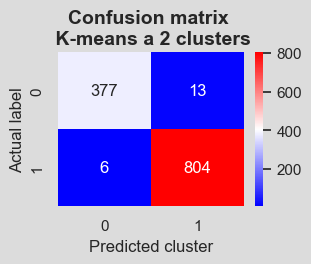

In [27]:
# heatmap of confusion matrix
conf_km2 = confusion_matrix(clusters['real_label'], clusters['predicted_labels_km2'])
fig, ax = plt.subplots(figsize=(3, 2))
conf_km2 = pd.DataFrame(conf_km2)
sns.heatmap(conf_km2, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means a 2 clusters', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_km2.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

def matrice_confusion(a, b, nom_graphique):
    confusion_matrix = metrics.confusion_matrix(a, b)
    group_names = ['Vrais négatifs','Faux positifs', 'Faux négatifs', 'Vrais positifs']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix.flatten() / np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title(nom_graphique)
    plt.show()
    
    classification = metrics.classification_report(a, b)
    print(classification)

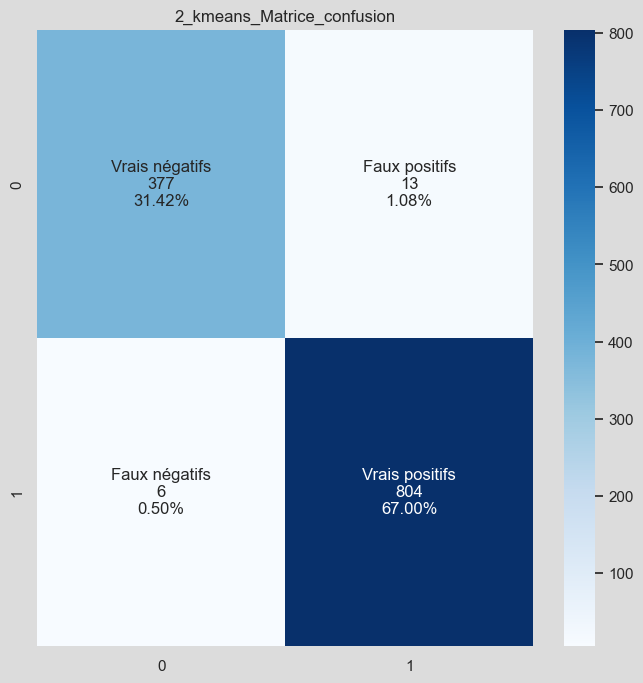

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       390
           1       0.98      0.99      0.99       810

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [29]:
matrice_confusion(clusters['real_label'], clusters['predicted_labels_km2'], "2_kmeans_Matrice_confusion")

- Sur 810 vrais billets, 6 sont predits faux (0.7% de faux negatifs). 

- Sur 390 faux billets, 13 sont predits vrais (3.33% de faux positifs).

### Performances du modèle à 2 Clusters sur train set

In [30]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters['is_genuine'], clusters['predicted_labels_km2']))

# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters['is_genuine'], clusters['predicted_labels_km2']))

from sklearn.metrics import accuracy_score

print("accuracy_score",accuracy_score(clusters['is_genuine'], clusters['predicted_labels_km2']))

print("MIB:", normalized_mutual_info_score (clusters['is_genuine'], clusters['predicted_labels_km2']))

print("Adjusted MIB:", adjusted_mutual_info_score(clusters['is_genuine'], clusters['predicted_labels_km2']))
print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['predicted_labels_km2']))

Rand score: 0.9688087294968029
Adjusted rand score: 0.9366134581986845
accuracy_score 0.9841666666666666
MIB: 0.8740066833488348
Adjusted MIB: 0.8739229387961293
FM score: 0.9723037747907189


### Fowlkes-Mallows Score

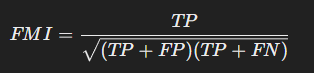

Le score Fowlkes-Mallows (FMI) est une mesure de similarité entre deux ensembles d'étiquettes, souvent utilisée pour évaluer la qualité des algorithmes de clustering. 

- Il est défini comme la racine carrée de la proportion du nombre de paires d'éléments qui sont dans la même classe à la fois dans les ensembles d'étiquettes et dans les clusters prédits, divisée par la racine carrée du produit du nombre total de paires d'éléments dans les deux ensembles.

Où :

TP (True Positives) : Le nombre de paires d'éléments qui sont dans la même classe à la fois dans les ensembles d'étiquettes et dans les clusters prédits.
FP (False Positives) : Le nombre de paires d'éléments qui sont dans la même classe dans les clusters prédits mais dans des classes différentes dans les ensembles d'étiquettes.
FN (False Negatives) : Le nombre de paires d'éléments qui sont dans la même classe dans les ensembles d'étiquettes mais dans des clusters différents dans les clusters prédits.

- Le score FMI varie entre 0 et 1, où 1 indique une parfaite correspondance entre les ensembles d'étiquettes et les clusters prédits, et 0 indique une absence de correspondance.

En résumé, le score Fowlkes-Mallows mesure à quel point les clusters prédits correspondent aux vrais groupements des données, en tenant compte à la fois des vrais positifs, des faux positifs et des faux négatifs.

In [31]:
print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['predicted_labels_km2']))

FM score: 0.9723037747907189


Un score Fowlkes-Mallows (FMI) de 0.9723 est un excellent résultat, indiquant une très bonne similarité entre les ensembles d'étiquettes (les vrais groupements des données) et les clusters prédits par notre algorithme de clustering.

matrice de confusion - 2 clusters

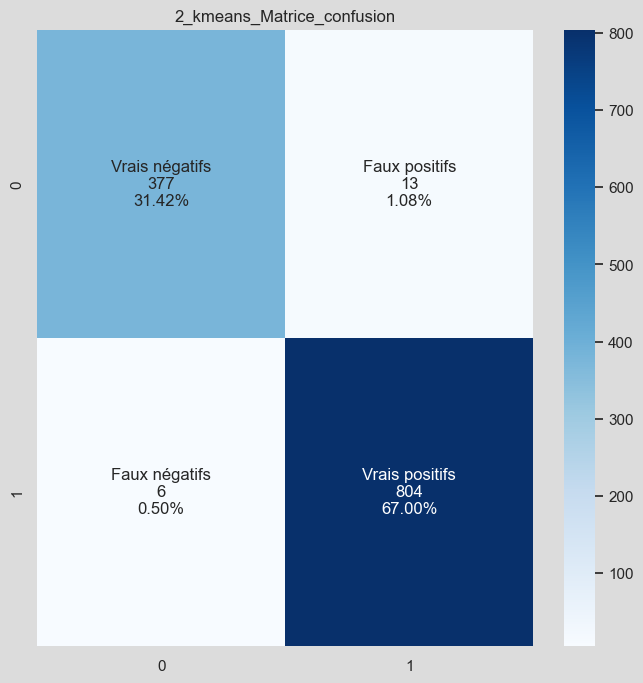

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       390
           1       0.98      0.99      0.99       810

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [32]:
matrice_confusion(clusters['real_label'], clusters['predicted_labels_km2'], "2_kmeans_Matrice_confusion")

### Evaluation de la performance du K-means à 2 Clusters sur le "testing set"

In [33]:
# scale data
x_test_scaled = std_scaler.transform(x_test)

# create dataframe to store results
clusters_test = pd.DataFrame(y_test)
clusters_test[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
               'length']] = x_test_scaled
clusters_test.loc[(clusters_test['is_genuine'] == True), 'labels_true'] = 1
clusters_test.loc[(clusters_test['is_genuine'] == False), 'labels_true'] = 0

# run K-means
kmeans_2.fit_predict(x_test_scaled)
labels_final_test = kmeans_2.labels_

# add cluster number to each country in clusters dataframe
clusters_test['cluster_pred_test_km2'] = (labels_final_test)
clusters_test.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
1116       False  0.985771    -0.432900      0.613193    0.786137   1.161177  \
1368       False -0.999222     0.962034      1.410179    1.789489   0.384374   
422         True -1.389712    -1.661771     -0.888817   -0.658082  -0.823987   
413         True  1.115935    -1.230006     -1.287310   -0.487741   0.039128   
451         True  0.692904    -0.798240     -1.164697   -0.612475  -1.600790   

        length  labels_true  cluster_pred_test_km2  
1116 -1.615898          0.0                      1  
1368 -0.443858          0.0                      1  
422   0.079577          1.0                      0  
413   0.295779          1.0                      0  
451   0.386811          1.0                      0

In [34]:
def assign_labels(cluster_values, real_labels):
    # Initialiser un dictionnaire pour stocker les correspondances entre les valeurs de cluster_km_2 et les labels réels
    cluster_to_label = {}
    
    # Parcourir les valeurs uniques de cluster_km_2
    for cluster_value in cluster_values.unique():
        # Sélectionner les labels réels correspondant à cette valeur de cluster_km_2
        labels_for_cluster = real_labels[cluster_values == cluster_value]
        
        # Calculer la valeur la plus fréquente parmi ces labels
        majority_label = labels_for_cluster.mode()[0]
        
        # Assigner la valeur majoritaire au dictionnaire de correspondance
        cluster_to_label[cluster_value] = majority_label
    
    # Utiliser le dictionnaire de correspondance pour attribuer les bonnes étiquettes True/False à chaque valeur de cluster_km_2
    predicted_labels = cluster_values.map(cluster_to_label)
    
    return predicted_labels

# Assigner les bonnes étiquettes True/False à chaque valeur de cluster_pred_test
clusters_test['predicted_labels_test_km2'] = assign_labels(clusters_test['cluster_pred_test_km2'], clusters_test['labels_true'])


### Matrice de confusion - 2 Clusters - test set

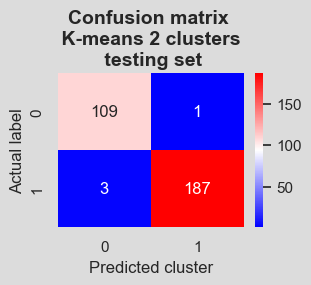

In [35]:
# heatmap of confusion matrix
conf_kmtest = confusion_matrix(clusters_test['labels_true'], clusters_test['predicted_labels_test_km2'])
fig, ax = plt.subplots(figsize=(3, 2))
conf_kmtest = pd.DataFrame(conf_kmtest)
sns.heatmap(conf_kmtest, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means 2 clusters \n testing set', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_kmtest.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

***********************************************************************

### Performances du modèle 2 Clusters sur le jeu test

In [36]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters_test['is_genuine'], clusters_test['predicted_labels_test_km2']))
      
# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters_test['is_genuine'], clusters_test['predicted_labels_test_km2']))

print("MIB:", normalized_mutual_info_score (clusters_test['is_genuine'], clusters_test['predicted_labels_test_km2']))

print("Adjusted MIB:", adjusted_mutual_info_score(clusters_test['is_genuine'], clusters_test['predicted_labels_test_km2']))

print("FM score:", fowlkes_mallows_score(clusters_test['is_genuine'], clusters_test['predicted_labels_test_km2']))

Rand score: 0.9736008918617615
Adjusted rand score: 0.9469816764574738
MIB: 0.8958662114412843
Adjusted MIB: 0.8956005456730549
FM score: 0.9752062780873688


### Prediction sur l'echantillon de production avec l'algorithme de classification KMeans 2 Clusters

In [50]:
# Import data
data_prod = pd.read_csv("billets_production.csv", encoding='latin_1')

# check for missing values
if (data_prod.loc[data_prod.isna().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs manquantes !!!")
else:
    print ("Pas de valeurs manquantes.")
# check for missing data
if (data_prod.loc[data_prod.isnull().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs nulles !!! ")
else:
    print ("Pas de valeurs nulles.")
# check for duplicates
if (data_prod.loc[data_prod.duplicated() == True].shape[0]) != 0:
    print("!!! Doublons dans la table !!!")
else:
    print ("Pas de doublons dans la table.")

Pas de valeurs manquantes.
Pas de valeurs nulles.
Pas de doublons dans la table.


In [53]:
# split file
banknote_production = data_prod[['diagonal', 'height_left', 'height_right', 'margin_low',
                      'margin_up', 'length']].values

# scale data
banknote_production = std_scaler.transform(banknote_production)

# run K-means
kmeans_2.fit_predict(banknote_production)
labels_final = kmeans_2.labels_

# add cluster number to each occurence in clusters dataframe
data_prod['cluster_pred_prod'] = (labels_final)

data_prod

diagonal  height_left  height_right  margin_low  margin_up  length   id   
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1  \
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   cluster_pred_prod  
0                  0  
1                  0  
2                  0  
3                  0  
4                  1

In [56]:
# print results
print("Resultats:\n")
for k, l in zip(data_prod["cluster_pred_prod"], data_prod["id"]):
    if k == 1:
        print(f"Le billet ref. {l} est un vrai billet.")
    else:
        print(f"Le billet ref. {l} est un faux billet.")

Resultats:

Le billet ref. A_1 est un faux billet.
Le billet ref. A_2 est un faux billet.
Le billet ref. A_3 est un faux billet.
Le billet ref. A_4 est un faux billet.
Le billet ref. A_5 est un vrai billet.


**************************************************************************************************

********************************************************************

# Entrainement de l'algorithme K-means à 3 Clusters

## Algorithme de clasification K-means à 3 clusters sur train set

In [91]:
# run K-means
kmeans_3 = KMeans(n_clusters=3, random_state=808, n_init="auto")
kmeans_3.fit(x_train_scaled)
labels_3 = kmeans_3.labels_

# add cluster number to each line in "clusters dataframe"
clusters['cluster_km_3'] = kmeans_3.labels_


In [92]:
# create centroids dataframe
centroids_3 = kmeans_3.cluster_centers_
centroids_km_3 = pd.DataFrame(centroids_3)
centroids_km_3.columns = dimensions
centroids_km_3

diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.301036    -0.994899     -0.481869   -0.511861  -0.480123  0.573136
1  0.470384     0.464245     -0.195861   -0.560665  -0.345104  0.585752
2 -0.190838     0.557189      0.728224    1.157713   0.888955 -1.250511

In [93]:
# plot polar chart centroids
categories = centroids_km_3.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_3.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_3.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_3.iloc[2], theta=categories, fill='toself', name='Cluster 3 centroide'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.show()

### Assignation des labels réels en fonction des numéros de Clusters 

In [94]:
def assign_labels(cluster_values, real_labels):
    # Initialiser un dictionnaire pour stocker les correspondances entre les valeurs de cluster_km_3 et les labels réels
    cluster_to_label = {}
    
    # Parcourir les valeurs uniques de cluster_km_3
    for cluster_value in cluster_values.unique():
        # Sélectionner les labels réels correspondant à cette valeur de cluster_km_3
        labels_for_cluster = real_labels[cluster_values == cluster_value]
        
        # Calculer la valeur la plus fréquente parmi ces labels
        majority_label = labels_for_cluster.mode()[0]
        
        # Assigner la valeur majoritaire au dictionnaire de correspondance
        cluster_to_label[cluster_value] = majority_label
    
    # Utiliser le dictionnaire de correspondance pour attribuer les bonnes étiquettes True/False à chaque valeur de cluster_km_2
    predicted_labels = cluster_values.map(cluster_to_label)
    
    return predicted_labels

# Assigner les bonnes étiquettes True/False à chaque valeur de cluster_km_3
clusters['predicted_labels_km3'] = assign_labels(clusters['cluster_km_3'], clusters['real_label'])


### Matrice de confusion - KMeans à 3 clusters - Train set

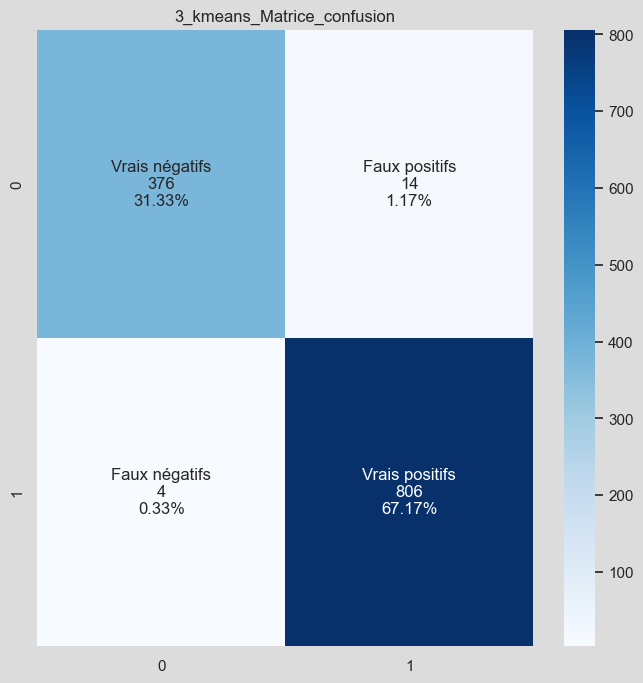

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       390
           1       0.98      1.00      0.99       810

    accuracy                           0.98      1200
   macro avg       0.99      0.98      0.98      1200
weighted avg       0.99      0.98      0.98      1200



In [95]:
matrice_confusion(clusters['real_label'], clusters['predicted_labels_km3'], "3_kmeans_Matrice_confusion")

In [96]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters['is_genuine'], clusters['predicted_labels_km3']))
      
# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters['is_genuine'], clusters['predicted_labels_km3']))
print("accuracy_score",accuracy_score(clusters['is_genuine'], clusters['predicted_labels_km3']))
print("MIB:", normalized_mutual_info_score (clusters['is_genuine'], clusters['predicted_labels_km3']))

print("Adjusted MIB:", adjusted_mutual_info_score(clusters['is_genuine'], clusters['predicted_labels_km3']))

print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['predicted_labels_km3']))

Rand score: 0.9704253544620517
Adjusted rand score: 0.9398716299079545
accuracy_score 0.985
MIB: 0.8813890486809433
Adjusted MIB: 0.8813100902636228
FM score: 0.9737890998256999


********************************************

## Algorithme de classification K-means à 3 clusters sur test set

In [76]:
# scale data
x_test_scaled = std_scaler.transform(x_test)

# create dataframe to store results
clusters_test_km_3 = pd.DataFrame(y_test)
clusters_test_km_3[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
               'length']] = x_test_scaled
clusters_test_km_3.loc[(clusters_test_km_3['is_genuine'] == True), 'labels_true'] = 1
clusters_test_km_3.loc[(clusters_test_km_3['is_genuine'] == False), 'labels_true'] = 0

# run K-means
kmeans_3.fit_predict(x_test_scaled)
labels_final_test = kmeans_3.labels_

# add cluster number to each occurence in clusters dataframe
clusters_test_km_3['cluster_pred_test_km3'] = (labels_final_test)
clusters_test_km_3

is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
1116       False  1.047699    -0.812587      0.421012    0.144293   1.425709  \
1368       False -1.040852     0.372436      1.160628    1.026085   0.015667   
422         True -1.451714    -1.856536     -0.972879   -1.124953  -2.177731   
413         True  1.184654    -1.489743     -1.342687   -0.975249  -0.611018   
451         True  0.739553    -1.122950     -1.228900   -1.084871  -3.587773   
...          ...       ...          ...           ...         ...        ...   
983         True  1.287369    -1.405099     -0.887539   -1.499046  -1.159368   
799         True  1.869425    -0.445794     -0.517731   -0.817662  -2.647745   
1265       False  1.424323     0.993162      0.164991    1.253214   1.347373   
1150       False -0.561512     1.896037      1.046841    0.678713  -0.767689   
824         True  0.499883    -0.276505     -0.403944   -0.523731   0.094003   

        length  labels_true  cluster_pred_test_km3  
1116 -1.310934          0.0                      1  
1368 -0.027415          0.0                      1  
422   0.545807          1.0                      2  
413   0.782573          1.0                      0  
451   0.882264          1.0                      2  
...        ...          ...                    ...  
983   1.667329          1.0                      0  
799   0.495962          1.0                      2  
1265 -1.086630          0.0                      1  
1150  0.869802          0.0                      1  
824   1.305950          1.0                      0  

[300 rows x 9 columns]

In [77]:
# Assigner les bonnes étiquettes True/False à chaque valeur de cluster_km_3
clusters_test_km_3['predicted_labels_km3'] = assign_labels(clusters_test_km_3['cluster_pred_test_km3'], clusters_test_km_3['labels_true'])

In [78]:
clusters_test_km_3

is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
1116       False  1.047699    -0.812587      0.421012    0.144293   1.425709  \
1368       False -1.040852     0.372436      1.160628    1.026085   0.015667   
422         True -1.451714    -1.856536     -0.972879   -1.124953  -2.177731   
413         True  1.184654    -1.489743     -1.342687   -0.975249  -0.611018   
451         True  0.739553    -1.122950     -1.228900   -1.084871  -3.587773   
...          ...       ...          ...           ...         ...        ...   
983         True  1.287369    -1.405099     -0.887539   -1.499046  -1.159368   
799         True  1.869425    -0.445794     -0.517731   -0.817662  -2.647745   
1265       False  1.424323     0.993162      0.164991    1.253214   1.347373   
1150       False -0.561512     1.896037      1.046841    0.678713  -0.767689   
824         True  0.499883    -0.276505     -0.403944   -0.523731   0.094003   

        length  labels_true  cluster_pred_test_km3  predicted_labels_km3  
1116 -1.310934          0.0                      1                   0.0  
1368 -0.027415          0.0                      1                   0.0  
422   0.545807          1.0                      2                   1.0  
413   0.782573          1.0                      0                   1.0  
451   0.882264          1.0                      2                   1.0  
...        ...          ...                    ...                   ...  
983   1.667329          1.0                      0                   1.0  
799   0.495962          1.0                      2                   1.0  
1265 -1.086630          0.0                      1                   0.0  
1150  0.869802          0.0                      1                   0.0  
824   1.305950          1.0                      0                   1.0  

[300 rows x 10 columns]

#### Matrice de confusion & Performances - 3 Clusters - Test Set

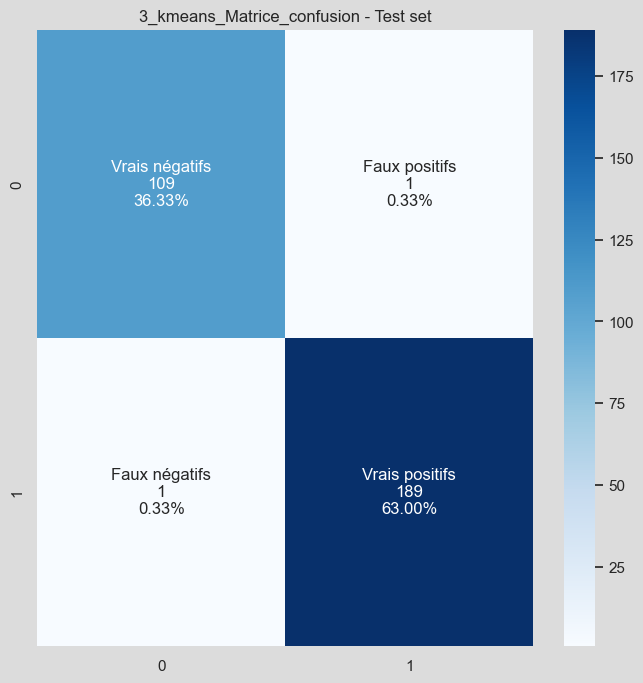

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       110
         1.0       0.99      0.99      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [62]:
matrice_confusion(clusters_test_km_3['labels_true'], clusters_test_km_3['predicted_labels_km3'], "3_kmeans_Matrice_confusion - Test set")

In [63]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters_test_km_3['is_genuine'], clusters_test_km_3['predicted_labels_km3']))
      
# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters_test_km_3['is_genuine'], clusters_test_km_3['predicted_labels_km3']))

print("MIB:", normalized_mutual_info_score (clusters_test_km_3['is_genuine'], clusters_test_km_3['predicted_labels_km3']))

print("Adjusted MIB:", adjusted_mutual_info_score(clusters_test_km_3['is_genuine'], clusters_test_km_3['predicted_labels_km3']))

print("FM score:", fowlkes_mallows_score(clusters_test_km_3['is_genuine'], clusters_test_km_3['predicted_labels_km3']))

Rand score: 0.9867112597547381
Adjusted rand score: 0.9732990380677448
MIB: 0.9394345891859972
Adjusted MIB: 0.9392796473703022
FM score: 0.9875574112734864


# Prédiction sur l'echantillon de production - modèle à 3 clusters

#### Programme

In [79]:
# Import data
data_prod = pd.read_csv("billets_production.csv", encoding='latin_1')

# check for missing values
if (data_prod.loc[data_prod.isna().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs manquantes !!!")
else:
    print ("Pas de valeurs manquantes.")
# check for missing data
if (data_prod.loc[data_prod.isnull().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs nulles !!! ")
else:
    print ("Pas de valeurs nulles.")
# check for duplicates
if (data_prod.loc[data_prod.duplicated() == True].shape[0]) != 0:
    print("!!! Doublons dans la table !!!")
else:
    print ("Pas de doublons dans la table.")

Pas de valeurs manquantes.
Pas de valeurs nulles.
Pas de doublons dans la table.


In [88]:
# split file
x_prod_1 = data_prod[['diagonal', 'height_left', 'height_right', 'margin_low',
                      'margin_up', 'length']].values

# scale data
x_prod_1_scaled = std_scaler.transform(x_prod_1)

# run K-means
kmeans_3.fit_predict(x_prod_1_scaled)
labels_final = kmeans_3.labels_

# add cluster number to each occurence in clusters dataframe
data_prod['cluster_pred_prod_km3'] = (labels_final)

# Création d'un dictionnaire pour mapper les numéros de cluster à des étiquettes Vrai ou Faux
cluster_to_label = {1: False, 2: True, 0: True}

# Application du mapping pour obtenir les étiquettes correspondantes
data_prod['cluster_label'] = data_prod['cluster_pred_prod_km3'].map(cluster_to_label)

# Affichage du DataFrame avec les étiquettes assignées à chaque cluster
data_prod


diagonal  height_left  height_right  margin_low  margin_up  length   id   
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1  \
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   cluster_pred_prod_km3  cluster_label  
0                      1          False  
1                      1          False  
2                      1          False  
3                      2           True  
4                      0           True

In [89]:
# print results
print("Resultats:\n")
for k, l in zip(data_prod["cluster_pred_prod_km3"], data_prod["id"]):
    if k != 1:
        print(f"Le billet ref. {l} est un vrai billet.")
    else:
        print(f"Le billet ref. {l} est un faux billet.")

Resultats:

Le billet ref. A_1 est un faux billet.
Le billet ref. A_2 est un faux billet.
Le billet ref. A_3 est un faux billet.
Le billet ref. A_4 est un vrai billet.
Le billet ref. A_5 est un vrai billet.
